In [1]:
import tsflex
print(tsflex.__version__)

0.1.1.9


## Get the data

In [2]:
import pandas as pd

url = "https://github.com/predict-idlab/tsflex/raw/main/examples/data/empatica/"
df_tmp = pd.read_parquet(url+"tmp.parquet").set_index("timestamp")
df_acc = pd.read_parquet(url+"acc.parquet").set_index("timestamp")
df_gsr = pd.read_parquet(url+"gsr.parquet").set_index("timestamp")
df_ibi = pd.read_parquet(url+"ibi.parquet").set_index("timestamp")

In [3]:
from pandas.tseries.frequencies import to_offset

data = [df_tmp, df_acc, df_gsr, df_ibi]
for df in data:
    print("Time-series:", df.columns.values)
    print(df.shape)
    try:
        print("Sampling rate:", 1 / pd.to_timedelta(to_offset(pd.infer_freq(df.index))).total_seconds(), "Hz")
    except:
        print("Irregular sampling rate")
    print()

Time-series: ['TMP']
(30200, 1)
Sampling rate: 4.0 Hz

Time-series: ['ACC_x' 'ACC_y' 'ACC_z']
(241620, 3)
Sampling rate: 32.0 Hz

Time-series: ['EDA']
(30204, 1)
Sampling rate: 4.0 Hz

Time-series: ['IBI']
(1230, 1)
Irregular sampling rate



## Look at the data

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=len(data), cols=1, shared_xaxes=True, 
    subplot_titles=[df.columns.values[0].split('_')[0] for df in data]
)

for plot_idx, df in enumerate(data, 1):
    # Select first minute of data
    sub_df = df.first('1min')
    for col in df.columns:
        fig.add_trace(
            go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
            row=plot_idx, col=1
        )

fig.update_layout(height=len(data)*200)

fig.show(renderer='iframe')

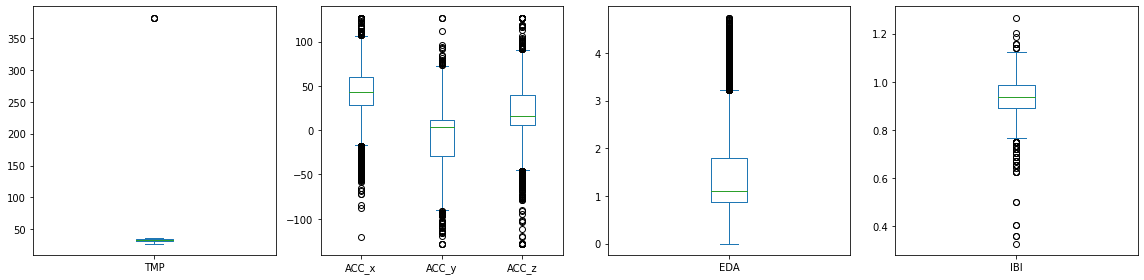

In [5]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

These visualizations indicate that some preprocessing might be necessary for the signals (some sort of clipping)

# tsflex processing

This is roughly identical to the processing of notebook containing the example code of the paper.

In [6]:
from tsflex.processing import SeriesProcessor, SeriesPipeline

# Import / create the processing functions
import numpy as np
from scipy.signal import savgol_filter

def clip_quantiles(sig: pd.Series, lower_q=0.01, upper_q=0.99) -> np.ndarray:
    # Note that this function induces a data leakage
    quantile_vals = np.quantile(sig, q=[lower_q, upper_q])
    return np.clip(sig, *quantile_vals)

def smv(*sigs) -> pd.Series:
    sig_prefixes = set(sig.name.split('_')[0] for sig in sigs)
    result = np.sqrt(np.sum([np.square(sig) for sig in sigs], axis=0))
    return pd.Series(result, index=sigs[0].index, name='|'.join(sig_prefixes)+'_'+'SMV')

# Create the series processors (with their keyword arguments)
clipper_tmp = SeriesProcessor(clip_quantiles, series_names="TMP", lower_q=0, upper_q=0.999)
savgol_eda = SeriesProcessor(savgol_filter, "EDA", window_length=5, polyorder=2)
savgol_acc = SeriesProcessor(savgol_filter, ["ACC_x", "ACC_y", "ACC_z"], window_length=33, polyorder=2)
smv_processor = SeriesProcessor(smv, ("ACC_x", "ACC_y", "ACC_z"))

# Create the series pipeline
series_pipe = SeriesPipeline(
    processors=[clipper_tmp, savgol_eda, savgol_acc, smv_processor]
)
series_pipe

[
	clip_quantiles {'lower_q': 0, 'upper_q': 0.999} :  ('TMP',)
	savgol_filter {'window_length': 5, 'polyorder': 2} :  ('EDA',)
	savgol_filter {'window_length': 33, 'polyorder': 2} :  ('ACC_x',) ('ACC_y',) ('ACC_z',)
	smv {} :  ('ACC_x', 'ACC_y', 'ACC_z')
]

In [7]:
out_data = series_pipe.process(data, drop_keys=["ACC_x", "ACC_y", "ACC_z"])

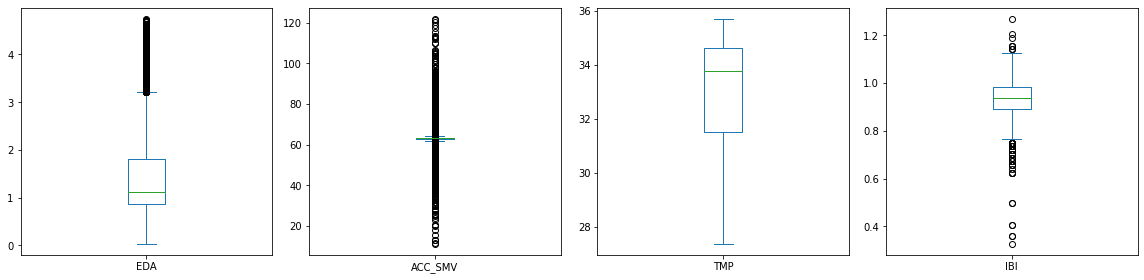

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for plot_idx, df in enumerate(out_data):
    df.plot(kind='box', ax=axes[plot_idx])
plt.tight_layout()

# tsflex feature extraction with [seg-learn](https://github.com/dmbee/seglearn) integration

In [ ]:
!pip install seglearn

As [seg-learn feature-functions](https://github.com/dmbee/seglearn/blob/master/seglearn/feature_functions.py) are vectorized along the first axis (axis=0), we need to expand our window-data.  
=> convert `1D np.array` to a `2D np.array` with all the window data in `axis=1`

In [10]:
from typing import Callable

# Decorator for seglearn functions doing the conversion (mentioned above)
def seglearn_wrapper(func: Callable) -> Callable:
    def wrap_func(x: np.ndarray):
        return func(x.reshape(1,len(x)))
    return wrap_func

## Using basic seg-learn features

In [11]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection, FuncWrapper

# Import base feature functions from seg-learn
from seglearn.feature_functions import base_features

general_feats = MultipleFeatureDescriptors(
        functions=[FuncWrapper(seglearn_wrapper(f), k) for k, f in base_features().items()],
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides="2min",
    )
feature_collection = FeatureCollection(general_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['min'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['max'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['kurt'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['mse'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['mnx'], {}),
	]
	win: 2m30s , stride: 2m: [
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['abs_energy'], {

In [12]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__abs_energy__w=5m_s=2m,ACC_SMV__min__w=5m_s=2m,ACC_SMV__mean__w=5m_s=2m,ACC_SMV__max__w=5m_s=2m,ACC_SMV__var__w=5m_s=2m,ACC_SMV__std__w=5m_s=2m,ACC_SMV__mean__w=2m30s_s=2m,ACC_SMV__median__w=5m_s=2m,EDA__mean__w=2m30s_s=2m,ACC_SMV__abs_energy__w=2m30s_s=2m,...,EDA__skew__w=2m30s_s=2m,TMP__median__w=2m30s_s=2m,TMP__mse__w=5m_s=2m,EDA__kurt__w=2m30s_s=2m,TMP__var__w=2m30s_s=2m,TMP__mse__w=2m30s_s=2m,TMP__skew__w=5m_s=2m,TMP__kurt__w=5m_s=2m,TMP__kurt__w=2m30s_s=2m,TMP__skew__w=2m30s_s=2m
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,62.975757,NaN,0.550201,1.908184e+07,...,0.268009,27.610001,NaN,6.113137,0.565926,465216.344060,NaN,NaN,75.956413,7.585334
2017-06-13 14:26:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,63.155303,NaN,0.681127,1.919667e+07,...,-0.003527,29.110001,NaN,1.503346,0.144238,504830.393464,NaN,NaN,-0.952384,-0.493916
2017-06-13 14:27:13+02:00,3.833208e+07,35.954740,63.109737,92.325941,10.086518,3.175928,NaN,63.092027,NaN,NaN,...,NaN,NaN,9.787109e+05,NaN,NaN,NaN,1.460693,10.492596,NaN,NaN
2017-06-13 14:28:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,62.903173,NaN,0.867796,1.900028e+07,...,-3.434356,30.059999,NaN,12.038491,0.130626,538692.068494,NaN,NaN,-1.622913,-0.271463
2017-06-13 14:29:13+02:00,3.821475e+07,44.753951,63.044016,92.325941,6.155085,2.480944,NaN,62.901436,NaN,NaN,...,NaN,NaN,1.048903e+06,NaN,NaN,NaN,-0.312452,-1.085054,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-06-13 16:23:13+02:00,3.815810e+07,56.499094,63.042887,69.608959,0.396584,0.629749,NaN,62.953852,NaN,NaN,...,NaN,NaN,1.109715e+06,NaN,NaN,NaN,-0.256389,-1.435013,NaN,NaN
2017-06-13 16:24:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,63.051531,NaN,0.812928,1.910876e+07,...,0.020514,30.930000,NaN,-1.739133,0.002582,574609.351628,NaN,NaN,-1.067320,0.311723
2017-06-13 16:25:13+02:00,3.820289e+07,40.374098,63.055640,82.316042,3.454283,1.858570,NaN,63.041110,NaN,NaN,...,NaN,NaN,1.141975e+06,NaN,NaN,NaN,-1.264685,0.349283,NaN,NaN


### Plot the EDA features

In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')

## Using all seg-learn features

In [14]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection, FuncWrapper

# Import all feature functions from seg-learn
from seglearn.feature_functions import all_features

general_feats = MultipleFeatureDescriptors(
        functions=[FuncWrapper(seglearn_wrapper(f), k) for k, f in all_features().items()],
        series_names=["ACC_SMV", "EDA", "TMP"],
        windows=["5min", "2.5min"],
        strides=["2.5min"],
    )
feature_collection = FeatureCollection(general_feats)
feature_collection

ACC_SMV: (
	win: 5m    , stride: 2m30s: [
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['gmean'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['hmean'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['vec_sum'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['abs_sum'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['mad'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['variation'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['min'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['max'], {}),
		FeatureDescriptor - func: FuncWrapper(wrap_func, ['skew'], {}),
		FeatureDescripto

In [15]:
features_df = feature_collection.calculate(out_data, return_df=True)
features_df

,ACC_SMV__vec_sum__w=5m_s=2m30s,ACC_SMV__mean__w=5m_s=2m30s,ACC_SMV__abs_sum__w=5m_s=2m30s,ACC_SMV__abs_energy__w=5m_s=2m30s,ACC_SMV__min__w=5m_s=2m30s,ACC_SMV__hmean__w=5m_s=2m30s,ACC_SMV__max__w=5m_s=2m30s,ACC_SMV__std__w=5m_s=2m30s,ACC_SMV__median__w=5m_s=2m30s,ACC_SMV__var__w=5m_s=2m30s,...,TMP__zero_crossings__w=2m30s_s=2m30s,TMP__emg_var__w=2m30s_s=2m30s,TMP__waveform_length__w=2m30s_s=2m30s,TMP__root_mean_square__w=2m30s_s=2m30s,TMP__skew__w=5m_s=2m30s,TMP__slope_sign_changes__w=2m30s_s=2m30s,TMP__mean_abs_diff__w=2m30s_s=2m30s,TMP__mad__w=2m30s_s=2m30s,TMP__kurt__w=2m30s_s=2m30s,TMP__skew__w=2m30s_s=2m30s
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-06-13 14:24:43+02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,599.0,776.654968,10.389996,27.845297,NaN,598.0,0.017346,0.326174,75.956413,7.585334
2017-06-13 14:27:13+02:00,605853.471250,63.109737,605853.471250,3.833208e+07,35.954740,62.947225,92.325941,3.175928,63.092027,10.086518,...,599.0,857.252930,2.139997,29.254473,1.460693,598.0,0.003573,0.340997,-0.743905,-0.226681
2017-06-13 14:29:43+02:00,605584.777954,63.081748,605584.777954,3.826007e+07,44.753951,62.994249,92.325941,2.473283,62.937181,6.117127,...,599.0,915.798218,2.160006,30.236929,-0.368764,598.0,0.003606,0.088955,1.080655,-1.240494
2017-06-13 14:32:13+02:00,603119.889884,62.824989,603119.889884,3.791766e+07,41.660656,62.777776,81.441751,1.666353,62.854726,2.776734,...,599.0,953.577087,2.580021,30.854300,0.832689,598.0,0.004307,0.385475,-0.780394,0.565035
2017-06-13 14:34:43+02:00,601771.324996,62.684513,601771.324996,3.774950e+07,41.660656,62.635673,81.441751,1.700338,62.635014,2.891151,...,599.0,1046.888550,2.880007,32.328682,0.061728,598.0,0.004808,0.474432,-1.275342,-0.203421
2017-06-13 14:37:13+02:00,603388.122920,62.852929,603388.122920,3.813345e+07,11.223471,62.389622,121.564172,4.663060,62.717138,21.744128,...,599.0,1079.431885,2.910019,32.827316,-1.082298,598.0,0.004858,0.088955,0.926125,-0.951929
2017-06-13 14:39:43+02:00,604111.198743,62.928250,604111.198743,3.825194e+07,11.223471,62.417887,121.564172,4.961119,62.804672,24.612701,...,599.0,1067.159424,2.399990,32.640171,-1.020745,598.0,0.004007,0.311345,-1.533498,-0.211024
2017-06-13 14:42:13+02:00,601345.993076,62.640208,601345.993076,3.770820e+07,43.888400,62.572703,83.171716,2.035278,62.503425,4.142356,...,599.0,1097.953003,2.009964,33.107750,0.344797,598.0,0.003356,0.296515,-1.002241,0.583422
2017-06-13 14:44:43+02:00,602804.798114,62.792166,602804.798114,3.786640e+07,45.415474,62.766422,74.364764,1.249102,62.692099,1.560255,...,599.0,1145.315674,2.509998,33.814301,-0.313246,598.0,0.004190,0.163087,-0.821269,0.622996


### Plot the EDA features

In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, 
    subplot_titles=['Raw EDA data', 'EDA features']
)

fig.add_trace(
    go.Scattergl(x=df_gsr.index[::4*5], y=df_gsr['EDA'].values[::4*5], name='EDA', mode='markers'),
    row=1, col=1
)

ibi_feats = [c for c in features_df.columns if 'EDA_' in c and 'w=2m30s_' in c]

for col in ibi_feats:
    sub_df = features_df[[col]].dropna()
    fig.add_trace(
        go.Scattergl(x=sub_df.index, y=sub_df[col].values, name=col, mode='markers'),
        row=2, col=1
    )

fig.update_layout(height=2*350)

fig.show(renderer='iframe')